<center> <h1>Weighted Average Cost of Capital</h1> </center>
<center> <h4>Erick Daniel Rodríguez Villafuerte</h4> </center>

- [**Overview**](#Overview): Brief description of the problem and the model
- [**Setup**](#Setup): Runs any imports and other setup
- [**Inputs**](#Inputs): Defines the inputs for the model
- [**Cost of Equity**](#Cost-of-Equity): Model to get the CoE, calculated with a CAPM and the Market Value of Equity
- [**Cost of Debt**](#Cost-of-Debt): Model to get CoD and the Market Value of Debt based on the market rate of bonds approach
- [**WACC**](#WACC): Model to get the average rate that a company expects to pay to finance its assets
- [**Monte Carlo Simulations**](#Monte-Carlo-Simulations): Monte Carlo Simulations for the WACC 
- [**Outputs**](#Outputs): Shows the final output for the model

## Overview 

### Introduction
The goal of cost of capital estimation is to determine the weighted average cost of capital (WACC). This can broadly be broken down into two components: estimating the cost of equity and estimating the cost of debt.
- Cost of debt is usually estimated from the interest payments and book value of debt

### Problem Definition
 "X" fund is considering an investment in Walmart. As part of the decision-making process, our team is building a DCF model to value the stock. Another analyst is working on getting the free cash flows. This project's job is to determine the cost of capital for Walmart.

### Main Question
> Determine the WACC for Walmart. 

<div style="text-align: justify">  The market value of debt is estimated by valuing the individual debt instruments. Once we have a baseline estimate, we want to figure out the variability of that estimate. <br>Given the standard deviations in the Monte Carlo Inputs section, and assuming these variables all follow normal distributions, visualize the probability distribution of the WACC via a histogram and a probability table. Which of the variables has the greatest contribution to the WACC? We will run at least 10,000 Monte Carlo simulations</div>

### Notes
- **Returns are daily.** We will need to divide the risk free rate by 252 to get a daily rate.
    - After we get an estimate from CAPM, we will need to multiply it by 252.
- If there is not a specific day associated with a debt maturity, only a year, assume it is December 31st.
- If there is a range of coupons given, you can assume the midpoint of the range is the coupon.
- If there is not enough information to calculate a bond price, or the bond already expired, just use the principal as the market price of the bond.
- In addition to the information in the spreadsheets, we need to consider the following:
    - Walmart currently has a coupon bond trading in the market (details below).
    - The risk-free rate and LIBOR rates are also given in the inputs table. 
    - Also reference Walmart’s stock information in the inputs table.

## Setup

In [1]:
from dataclasses import dataclass
import numpy as np
import numpy_financial as npf
import pandas as pd
import statsmodels.api as sm
import datetime as dt
import random
import matplotlib.pyplot as plt
%matplotlib inline

## Inputs

In [2]:
@dataclass
class ModelInputs:
    bond_years: int = 15
    bond_coupon: float = .0525
    bond_price: float = 130.58
    bond_par: float = 100
    risk_free: float = 0.005
    price: float = 119.51
    shares_outstanding: int = 2850000000
    libor_rate: float = 0.0196
    sp_500_file: str = 'SP500 Prices.xlsx'
    stock_prices_file: str = 'WMT Prices.xlsx'
    stock_ticker: str = 'WMT'
    balance_sheet_file: str = 'WMT Balance Sheet.xlsx'
    income_statement_file: str = 'WMT Income Statement.xlsx'
    mv_debt_details_file: str = 'WMT Debt Details.xls'
        
        
@dataclass
class SimulationInputs:
    num_iter: int = 10000
    beta_std: float = 0.2
    mkt_ret_std: float = 0.03
    bond_price_std: float = 30
    tax_rate_std: float = 0.05

model_data = ModelInputs()
sim_data = SimulationInputs()

## Cost of Equity

Cost of equity is typically estimated using the Capital Asset Pricing Model (CAPM) <br><br>
$$r_i =r_f +\beta(r_m −r_f)+ \epsilon$$
Where:
- $r_i$ : Return on stock $i$
- $r_f$ : Return on risk free asset
- $r_m$: Return on market portfolio
- $\beta$: Covariance of stock returns with market risk premium
- $\epsilon$: Idiosyncratic return, mean 0

First step will be to convert into a DataFrame the values for the market and WMT stock.

In [3]:
df_m = pd.read_excel(model_data.sp_500_file)
df_i = pd.read_excel(model_data.stock_prices_file)

Now that we have both `DataFrames` we will just do a small sanity check. Dates should be the same, since WMT ticker operates in the same days as the SP500 does.

In [4]:
df_m['Date'].equals(df_i['Date'])

True

We confirm this and proceed to create a new `DataFrame` with only the columns that we need: Date and Adj Close for both the market and the asset, these last two will be renamed to avoid confusion and the first one (Date) will be used as index.

In [5]:
def combine_ohlc_dfs(data: ModelInputs, df_market, df_stock):
    '''
    Combines two DataFrames with OHLC format to just one DataFrame that keeps
    the same Date and the Adjusted Prices for the market and stock
    '''
    df = pd.concat([df_market['Date'], df_market['Adj Close'], df_stock['Adj Close']],
                   axis=1,
                   keys=['Date', 'Mkt Price', f'{data.stock_ticker} Price'])
    df = df.set_index('Date')
    return df
df_ohlc = combine_ohlc_dfs(model_data, df_m, df_i)
df_ohlc

,Mkt Price,WMT Price
Date,,
2014-11-06,2031.209961,68.586304
2014-11-07,2031.920044,69.432503
2014-11-10,2038.260010,70.023087
2014-11-11,2039.680054,69.644073
2014-11-12,2038.250000,69.811539
...,...,...
2019-10-30,3046.770020,118.099998
2019-10-31,3037.560059,117.260002
2019-11-01,3066.909912,117.620003


Beta will be calculated as the coefficient of the market risk premium in the regression of the historical stock returns and the historical market risk premiums.

In [6]:
def calculate_beta(data: ModelInputs, df):
    '''
    Given a df, calculates the beta of a stock by regressing the historical
    stock returns of the company on the historical market risk premiums
    '''
    returns = df.pct_change() # df has prices, this will change it to delta percentage
    # As stated before, risk free needs to be adjusted to daily values
    returns['MRP'] = returns['Mkt Price'] - (data.risk_free / 252) # MRP = Market Risk Premium
    returns = returns.dropna() # first value will be NA, needs to be dropped
    # Assign variables and fit the Ordinary Least Squares Model
    X = sm.add_constant(returns['MRP'])
    y = returns[f'{data.stock_ticker} Price']
    model = sm.OLS(y, X)
    results = model.fit()
    # Beta will be the coefficient of the market risk premium in the regression
    beta = results.params['MRP']
    return beta
beta = calculate_beta(model_data, df_ohlc)
beta

0.6248324465315513

This will be the first Capital Asset Princing Model, based on static inputs, later it will be changed to adapt variability.

In [7]:
def market_returns_average(data: ModelInputs, df):
    '''
    Given a df with market and stock prices, calculates the
    market returns average, will be used next for the capm
    '''
    returns = df.pct_change()
    returns['MRP'] = returns['Mkt Price'] - (data.risk_free / 252)
    MR_avg = returns['Mkt Price'].mean()
    return MR_avg * 252

mkt_ret_avg = market_returns_average(model_data, df_ohlc)
mkt_ret_avg

0.0923072636525422

In [8]:
def capm(data: ModelInputs, mkt_ret_avg, beta):
    '''
    Given an average of market returns, calculates the capital
    asset pricing model to get the cost of equity
    '''
    # Apply CAPM formula
    CoE = (data.risk_free / 252) + beta * (mkt_ret_avg / 252 - (data.risk_free / 252))
    # Adjust for anual cost of equity
    return CoE * 252

CoE = capm(model_data, mkt_ret_avg, beta)
CoE

0.05955241114799313

Lastly, we will get the market value of equity

In [9]:
equity_mv = model_data.shares_outstanding * model_data.price

---

## Cost of Debt

First we will load the necessary dataframes and assign a date variable to work with. For simplicity on this part, we will only be working with  Principal Due, Coupon Rate and Maturity on the Debt Details `DataFrame`, the rest of the columns will not be cleaned-up

In [10]:
df_bs = pd.read_excel(model_data.balance_sheet_file, index_col = 0) # balance sheet
df_is = pd.read_excel(model_data.income_statement_file, index_col = 0) # income statement 
df_dd = pd.read_excel(model_data.mv_debt_details_file, skiprows=12, nrows=62) # debt details
date = pd.to_datetime('2019-07-31')

First, we will replace '-' to `NaN` values in the Principal Due column, on the Coupon/Base Rate column, we will change the `NaN` vaelue to a space, this last change needs to be made for the next function `coupon_to_float`, which will take a string and convert it to a floating coupon rate.

In [11]:
df_dd['Principal Due (USD)'].replace('-', np.nan, inplace=True)
df_dd['Coupon/Base Rate'].fillna(value = '', inplace = True)

In [12]:
def coupon_to_float(string):
    '''
    Takes a string and converts '-' to '%', then it will convert the number 
    of the coupon as a float and divide it by 100, if there are two numbers, 
    it will take the average
    '''
    coupon = string.replace('-', '%').split('%')
    if len(coupon) == 2:
        cpn_r = float(coupon[0])
    elif len(coupon) == 4:
        high = float(coupon[2])
        low = float(coupon[0])
        cpn_r = (high + low) / 2
    else:
        cpn_r = 0
    return cpn_r / 100

def coupon_to_float_for_apply(series):
    """
    String to float in coupon rates.
    This version to be used with DataFrame.apply
    """
    coupon_rate = series['Coupon/Base Rate']
    return coupon_to_float(coupon_rate)

We apply the function and create a new column, 'Coupon Rate'

In [13]:
df_dd['Coupon Rate'] = df_dd.apply(coupon_to_float_for_apply, axis=1)

Now, the following functions two will take a value from the Maturity column, if it's a `datetime` then it will pass the same value, if it's an `integer`, it will convert it to a `datetime` and if there is no date (which in the table is a string value '-') it will pass it as `NaN`

In [14]:
def maturity_to_years(date):
    if isinstance(date, int):
        return dt.datetime.fromisoformat(f'{date}-12-31')
    elif isinstance(date, str):
        return np.NaN
    else:
        return date
    
def maturity_to_years_for_apply(series, date_col='Maturity'):
    """
    Integer to Datetime in Maturity column.
    This version to be used with DataFrame.apply
    """
    date = series[date_col]
    return maturity_to_years(date)

We apply the function and modify the 'Maturity' column

In [15]:
df_dd['Maturity'] = df_dd.apply(maturity_to_years_for_apply, axis=1)

The following two functions will determine the difference in years between today and a given date, in this case, the given date will be the Maturity date of each type of debt from WMT

In [16]:
def years_until_from_date(date):
    """
    Calculate the number of years until a date, starting from today.
    """
    today = dt.datetime.today()
    diff = date - today
    seconds = diff.total_seconds()
    seconds_per_year = 60 * 60 * 24 * 365
    years_elapsed = seconds / seconds_per_year
    return years_elapsed

def years_until_from_date_for_apply(series, date_col = 'Maturity'):
    date = series[date_col]
    return years_until_from_date(date)

We apply the function and create a new column, 'Maturity (years)'

In [17]:
df_dd['Maturity (years)'] = df_dd.apply(years_until_from_date_for_apply, axis=1)

Some of the years are negative and other some are `NaN`, we will not make a calculation for the market value of those bonds, we will create a new column to determine if we can apply the market value function (this function will be presented later)

In [18]:
def apply_mv_func(year):
    if year > 0:
        return True
    else:
        return False

We apply the function and create a new column, 'Apply MV Func'

In [19]:
df_dd['Apply MV Func'] = df_dd['Maturity (years)'].apply(lambda x: apply_mv_func(x))

We can now take a look at a DataFrame with the columns that will be used

In [20]:
df_dd[['Principal Due (USD)', 'Coupon Rate', 'Maturity (years)', 'Apply MV Func']]

,Principal Due (USD),Coupon Rate,Maturity (years),Apply MV Func
0,619.0,0.00183,1.499670,True
1,354.0,0.00298,3.510629,True
2,530.0,0.00520,6.505149,True
3,88.0,0.01600,-0.464714,False
4,1198.0,0.01750,-1.267454,False
...,...,...,...,...
57,42.0,0.00000,NaN,False
58,1243.0,0.03250,8.485971,True
59,1242.0,0.03050,5.483231,True
60,1493.0,0.02850,3.483231,True


The following functions will calculate the market value of debt based on the market rate of bonds approach. For this we need to have:
- Price
- Coupon
- Maturity
- Cost of debt

The first three elements will be taken from the cleaned-up dataframe, cost of debt will be calculated below with the rate formula based on the market bond inputs.

In [21]:
CoD = npf.rate(nper = model_data.bond_years, pmt = model_data.bond_coupon*model_data.bond_par, pv = -model_data.bond_price, fv = model_data.bond_par)
f'The pre-tax cost of debt for WMT is {CoD:.02%}'

'The pre-tax cost of debt for WMT is 2.74%'

In [22]:
def mv_bond_annuity_approach(principal, coupon_rate, maturity, cost_of_debt):
    """
    Calculate the market value of bond with non-integer maturity
    """
    coupon_payment = coupon_rate * principal
    return coupon_payment * ((1 - (1 + cost_of_debt)**(-maturity))/cost_of_debt) + principal/(1 + cost_of_debt)**maturity


def mv_bond_annuity_approach_for_apply(series, cost_of_debt):
    """
    Calculate market value of a bond with non-integer maturity. This version to be used with DataFrame.apply
    """
    principal = series['Principal Due (USD)']
    coupon_rate = series['Coupon Rate']
    maturity = series['Maturity (years)']
    return mv_bond_annuity_approach(principal, coupon_rate, maturity, cost_of_debt)

As stated before f `Maturity (years)` is negative we will not make a calculation for the market value of that bond, a column with a `bool`value has been created, this column will be set as an input for the following function `valid_value` check if the function will apply to that row.

In [23]:
def valid_mv_value(row):
    if row['Apply MV Func'] == False:
        row = row['Principal Due (USD)']
    else:
        row = mv_bond_annuity_approach_for_apply(row, CoD)
    return row

In [24]:
df_dd['Market Value'] = df_dd.apply(lambda row : valid_mv_value(row), axis=1) 

A last look at the DataFrame with the used columns

In [25]:
df_dd[['Principal Due (USD)', 'Coupon Rate', 'Maturity (years)', 'Apply MV Func', 'Market Value']]

,Principal Due (USD),Coupon Rate,Maturity (years),Apply MV Func,Market Value
0,619.0,0.00183,1.499670,True,596.077978
1,354.0,0.00298,3.510629,True,325.470958
2,530.0,0.00520,6.505149,True,460.845181
3,88.0,0.01600,-0.464714,False,88.000000
4,1198.0,0.01750,-1.267454,False,1198.000000
...,...,...,...,...,...
57,42.0,0.00000,NaN,False,42.000000
58,1243.0,0.03250,8.485971,True,1290.717737
59,1242.0,0.03050,5.483231,True,1261.551998
60,1493.0,0.02850,3.483231,True,1498.537429


Now we simply get the sum of all the bonds to get the debt market value

In [26]:
debt_mv = df_dd['Market Value'].sum()
debt_mv

82605.64576688924

---

## WACC

WACC is the average after-tax cost of a company’s various capital sources, including common stock, preferred stock, bonds, and any other long-term debt. In other words, WACC is the average rate a company expects to pay to finance its assets. 
> Note: preferred stock is not being considered for this project

$${WACC} = \biggl(\frac{E}{V} * R_e\biggr) + \biggl(\frac{D}{V} * R_d * (1 - T_c)\biggr)$$

Where:
- $E$ = Market value of the firm’s equity
- $D$ = Market value of the firm’s debt
- $V$ = $E + D$
- $R_e$ = Cost of equity
- $R_d$ = Cost of debt
- $T_c$ = Corporate tax rate

So far, we've calculated:
- [X] E
- [X] D
- [ ] V
- [X] $R_e$
- [X] $R_d$
- [ ] $T_c$

To get $V$ we will just add $E$ and $D$, important to notice that $D$ was given in millions, we need to multiply it so we have the same units as we got in $E$. <br>
To get $T_c$ we determine the effective tax rate using actual tax paid and EBT from the Income Statement

In [27]:
debt_mv = debt_mv * 1000000

In [28]:
tax_paid = df_is[date]['Income Tax Expense']
ebt = df_is[date]['Earnings before Tax']
tax_rate = tax_paid / ebt
f'The effective tax rate for {model_data.stock_ticker} is {tax_rate:.02%}'

'The effective tax rate for WMT is 25.46%'

We can now apply the complete WACC formula to a function and calculate it

In [29]:
def wacc_func(equity_mv, debt_mv, equity_cost, debt_cost, tax_rate):
    company_mv = equity_mv + debt_mv
    wacc = ((equity_mv/company_mv * equity_cost) + (debt_mv/company_mv * debt_cost * (1 - tax_rate)))
    return wacc
wacc = wacc_func(equity_mv, debt_mv, CoE, CoD, tax_rate)
print(f'WACC value for {model_data.stock_ticker} is {wacc:.2%}')

WACC value for WMT is 5.19%


---

## Monte Carlo Simulations

We run a Monte Carlo Simulation to predict the probability of different outcomes (in this case the WACC) when the intervention of random variables is present.

In [30]:
def wacc_simulations(data: ModelInputs, sdata: SimulationInputs, beta, mkt_ret, tax_rate, equity_mv, debt_mv):
    '''
    Creates a monte carlo simulation for the wacc value. The mean for the simulated values will be
    the already calculated value and their respective std will be the one given in the inputs
    '''
    beta_list = []
    mkt_ret_list = []
    bond_list = []
    tax_list = []
    wacc_list = []
    
    for i in range(sdata.num_iter):
        # random beta values based on the original value and the input std
        # then append them to a list
        beta_std = sdata.beta_std
        beta_mc = random.normalvariate(beta, beta_std)
        beta_list.append(beta_mc)
        
        # random market return values based on the original value and the input std
        # then append them to a list
        mkt_ret_avg_std = sdata.mkt_ret_std
        returns_mc = random.normalvariate(mkt_ret, mkt_ret_avg_std)
        mkt_ret_list.append(returns_mc)

        # capm model based on the simulated market return and beta
        coe_mc = capm(data, returns_mc, beta_mc)
        
        # random bond price values based on the original value and the input std
        # then append them to a list
        rand_bond_price = random.normalvariate(data.bond_price, sdata.bond_price_std)
        cod_mc = npf.rate(nper = data.bond_years,
                         pmt = data.bond_coupon * data.bond_par,
                         pv = -rand_bond_price,
                         fv = data.bond_par)
        bond_list.append(rand_bond_price)
        
        # random tax rate values based on the original value and the input std
        # then append them to a list
        tax_rate_std = sdata.tax_rate_std
        tax_rate_mc = random.normalvariate(tax_rate, tax_rate_std)
        tax_list.append(tax_rate_mc)
        
        # runs a wacc model based on the simulated data, then it appends
        # the values to a list
        wacc_mc = wacc_func(equity_mv, debt_mv, coe_mc, cod_mc, tax_rate_mc)
        wacc_list.append(wacc_mc)
        
        # Create a DataFrame based on all the simulated values
        wacc_df = pd.DataFrame(
            {'Beta': beta_list,
             'Market Return': mkt_ret_list,
             'Bond Price': bond_list,
             'Tax Rate': tax_list,
             'WACC': wacc_list
            })
    return wacc_df

wacc_df = wacc_simulations(model_data, sim_data, beta, mkt_ret_avg, tax_rate, equity_mv, debt_mv)

After running the monte carlo model, we can take a look at some of the simulation values.

In [31]:
display(wacc_df.head())
print(f'Number of simulations run: {len(wacc_df):,}')

,Beta,Market Return,Bond Price,Tax Rate,WACC
0,0.335373,0.081761,151.527937,0.151832,0.027083
1,0.712225,0.124410,118.904959,0.269812,0.077598
2,0.640917,0.079819,175.535828,0.260077,0.042837
3,0.874931,0.108511,199.516045,0.415302,0.075872
4,0.141387,0.067778,155.164354,0.281583,0.012860


Number of simulations run: 10,000


---

## Outputs

### Visualize
The following functions will display a histogram for the WACC and the probabilities 

In [32]:
def visualize_results(df):
    df.plot.hist(bins=100)
    plt.show()

def probability_table(df):
    percentiles = [i/20 for i in range(1, 20)]
    return df.quantile(percentiles)

def model_outputs(df):
    visualize_results(df)
    prob_table = probability_table(df)
    return prob_table

def display_model_summary(df):
    prob_table = model_outputs(df)
    print('Probability Table')
    print(prob_table.apply(lambda x: f'{x:.4%}'))

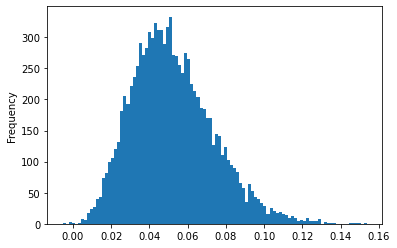

Probability Table
0.05    2.1192%
0.10    2.6761%
0.15    3.0563%
0.20    3.3948%
0.25    3.6769%
0.30    3.9604%
0.35    4.2192%
0.40    4.4665%
0.45    4.7297%
0.50    4.9872%
0.55    5.2476%
0.60    5.5396%
0.65    5.8494%
0.70    6.1499%
0.75    6.5174%
0.80    6.9345%
0.85    7.4591%
0.90    8.0679%
0.95    9.0730%
Name: WACC, dtype: object


In [33]:
display_model_summary(wacc_df['WACC'])

We can visualize the relationship of each variable with the WACC with a scatter plot

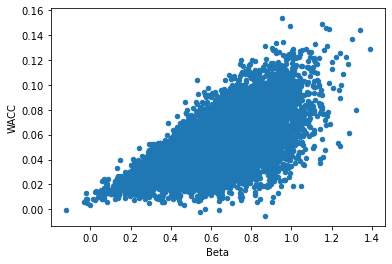

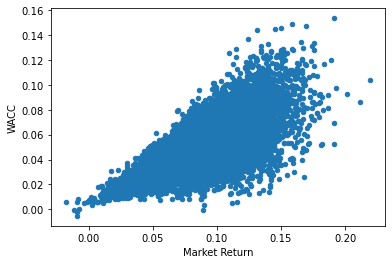

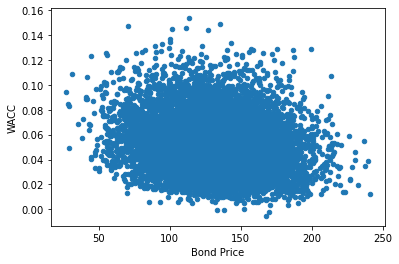

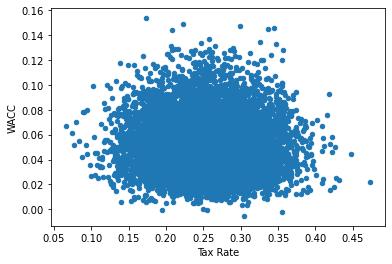

In [34]:
for col in ['Beta', 'Market Return', 'Bond Price', 'Tax Rate']:
    wacc_df.plot.scatter(x=col, y='WACC')

From the scatter plots we can infer that variables Beta and Market Return have a stronger impact on the WACC. <br>
We can take run a multilinear regression model to have a better understanding of the variables.

In [35]:
X = sm.add_constant(wacc_df[['Beta', 'Market Return', 'Bond Price', 'Tax Rate']])
y = wacc_df['WACC']
# After running the model several times, in some instances there is an NA value for WACC
# which would affect the model, hence we add the missing='drop'
model = sm.OLS(y, X, hasconst=True, missing='drop')
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   WACC   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                 4.441e+04
Date:                Wed, 13 Jan 2021   Prob (F-statistic):               0.00
Time:                        14:54:24   Log-Likelihood:                 38955.
No. Observations:                9998   AIC:                        -7.790e+04
Df Residuals:                    9993   BIC:                        -7.786e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0213      0.000    -53.820      0.000      -0.022      -0.020
Beta              0.0698      0.000    282.828      0.000       0.069       0.070
Market Return     0.4973      0.002    304.643      0.000       0.494       0.501
Bond Price       -0.0001   1.64e-06    -68.514      0.000      -0.000      -0.000
Tax Rate         -0.0048      0.001     -4.939      0.000      -0.007      -0.003
==============================================================================
Omnibus:                      998.376   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7907.412
Skew:                           0.083   Prob(JB):                         0.00
Kurtosis:                       7.354   Cond. No.                     4.46e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.46e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We create a `DataFrame` to see if there were any missing values, the ideal scenario would be to see this df empty

In [36]:
missing_values = wacc_df[wacc_df.isna().any(axis=1)]
missing_values

,Beta,Market Return,Bond Price,Tax Rate,WACC
2996,0.699875,0.087016,20.267027,0.263459,NaN
3494,0.555702,0.113593,21.132241,0.347609,NaN


To see which variables has a greater contribution to the WACC we standardize the coefficients.

In [37]:
wacc_df.std() * result.params

Beta             0.013909
Bond Price      -0.003374
Market Return    0.014985
Tax Rate        -0.000243
WACC                  NaN
const                 NaN
dtype: float64

Now we have the standardize coefficients, which makes it more clear, we can confirm what we saw on the scatter plots. The variables that have a greater impact on the WACC are Beta and the Market Return. <br><br>
All else constant and assuming we selected reasonable distribuitions:
- Beta: One std increase will **increase** WACC by approximately 1.4%
- Bond Price: One std increase will **decrease** WACC by approximately 0.34%
- Market Return: One std increase will **decrease** WACC by approximately 1.5%
- Tax Rate: One std increase will **increase** WACC by approximately 0.024%

---

[**Back to Top**](#Weighted-Average-Cost-of-Capital)